In [ ]:
import importlib
# 重新加载模块
import calc_cover_time
importlib.reload(calc_cover_time)
from calc_cover_time import *

In [2]:

from calc_cover_time import *
from scipy.optimize import dual_annealing
cover_time_hist = []
# 定义优化目标函数
missile_traj = get_missile_traj(M1, fake_target, v_M1, t_list)
def sa_objective(x):
    try:
        speed = x[0]
        direction_angle = x[1]
        throw_times = x[2:5]
        burst_delays = x[5:8]
        smoke_centers = get_smoke_center_multi(f1, direction_angle, speed, throw_times, burst_delays, t_list)
        cover_time = get_missile_cover_time_multi(smoke_centers, missile_traj, true_target, smoke_R, t_list)
        cover_time_hist.append(cover_time)
        return -cover_time
    except Exception:
        return 1e6  # 参数非法时返回极小值

# 参数边界：[速度, 角度, 投弹1, 投弹2, 投弹3, 爆炸1, 爆炸2, 爆炸3]
bounds = [
    (70, 140),           # speed
    (np.pi/2, np.pi *3 / 2),        # angle
    (0, 20), (1, 20), (2, 30),   # throw_times
    (0, 20), (1, 20), (2, 20),   # burst_delays
]
from tqdm.notebook import tqdm
max_iter = 4000
pbar = tqdm(total=max_iter, desc="退火优化进度")

# 定义回调函数，每次迭代后更新进度条
def progress_callback(x, f, context):
    pbar.update(1)  # 每次迭代更新进度条
result = dual_annealing(sa_objective,
                         bounds, 
                         maxiter=4000, 
                         seed=42,
                         callback=progress_callback,
                         initial_temp=10000,
                        )
print("最优参数:", result.x)
print("最大遮挡总时间:", -result.fun)

退火优化进度:   0%|          | 0/4000 [00:00<?, ?it/s]

最优参数: [1.38496388e+02 3.13266710e+00 4.64258780e-03 3.11481533e+00
 1.23361431e+01 3.73831081e+00 5.02280534e+00 8.14522459e+00]
最大遮挡总时间: 6.586


最优参数: [1.38496388e+02 3.13266710e+00 4.64258780e-03 3.11481533e+00
 1.23361431e+01 3.73831081e+00 5.02280534e+00 8.14522459e+00]
最大遮挡总时间: 6.586
每个烟雾球的遮挡时间及区间：
第1个烟雾球遮挡时间: 3.60s下面是各区间：    区间: 4.54s ~ 8.14s
第2个烟雾球遮挡时间: 2.99s下面是各区间：    区间: 8.14s ~ 11.13s
第3个烟雾球遮挡时间: 0.00s下面是各区间：
总遮挡区间：
    4.54s ~ 11.13s
总遮挡时间: 6.59s


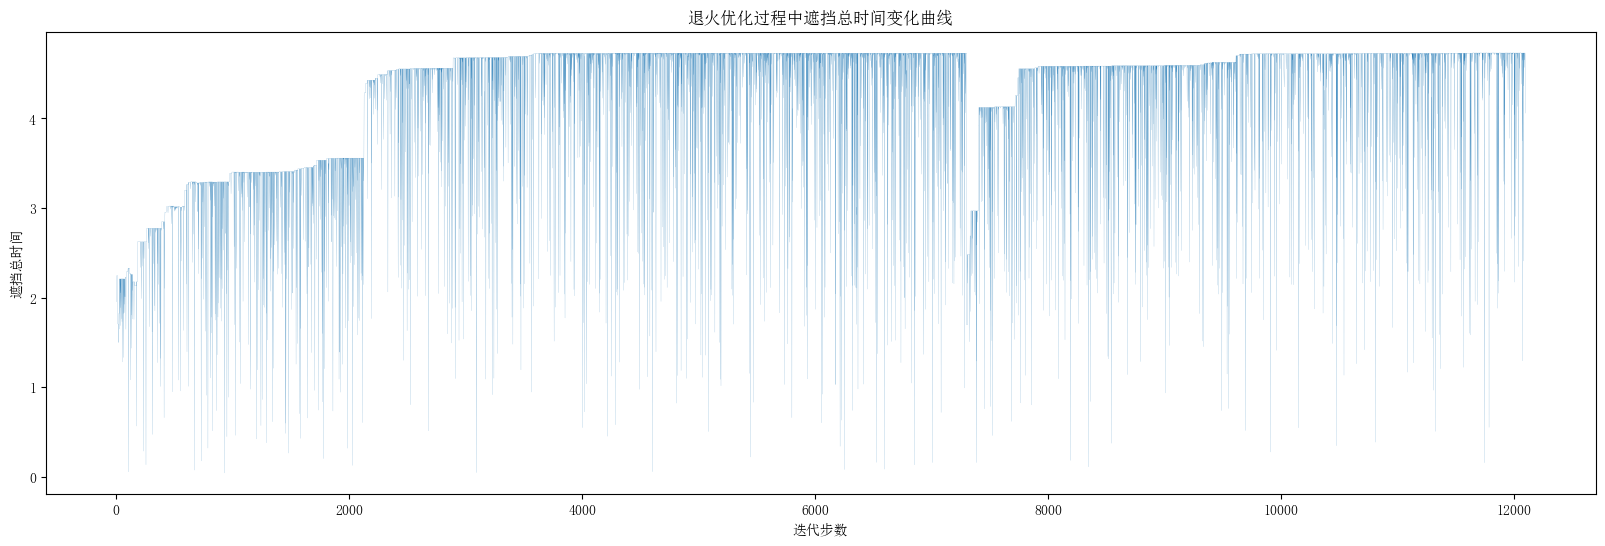

In [3]:
print('最优参数:', result.x)
print('最大遮挡总时间:', -result.fun)


smoke_centers = get_smoke_center_multi(f1, result.x[1], result.x[0], result.x[2:5], result.x[5:8]  , t_list)
cover_time = get_missile_cover_time_multi(smoke_centers, missile_traj, true_target, smoke_R, t_list, debug=True)


plt.figure(figsize=(20,6))
plt.plot([cover_time_01 for cover_time_01 in cover_time_hist[:22000] if cover_time_01 > 0], linewidth=0.1, label='遮挡总时间')
plt.xlabel('迭代步数')
plt.ylabel('遮挡总时间')
plt.title('退火优化过程中遮挡总时间变化曲线')
plt.show()


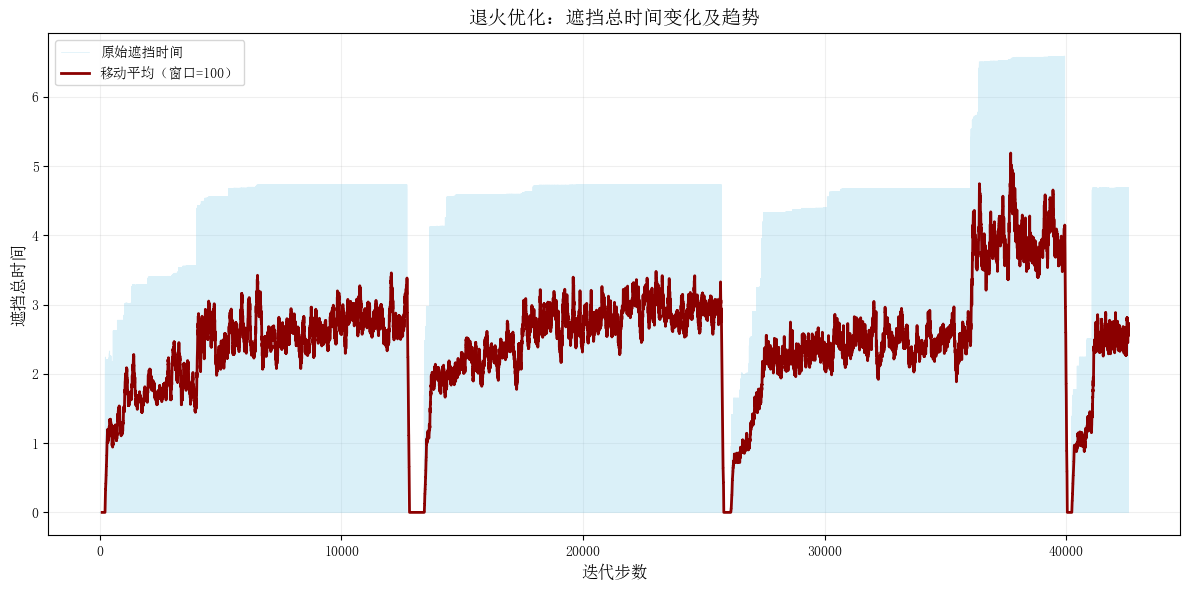

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

# 假设 cover_time_hist 是存储所有迭代遮挡时间的列表
ct_series = pd.Series(cover_time_hist)
window_size = 100  # 移动平均窗口大小，可根据数据密度调整
rolling_avg = ct_series.rolling(window=window_size).mean()

# 绘图
plt.figure(figsize=(12, 6))
# 原始数据：透明+细线，避免视觉拥挤
plt.plot(ct_series.index, ct_series.values, 
         color='skyblue', alpha=0.3, linewidth=0.5, 
         label='原始遮挡时间')
# 移动平均：粗线+醒目颜色，突出趋势
plt.plot(rolling_avg.index, rolling_avg.values, 
         color='darkred', linewidth=2, 
         label=f'移动平均（窗口={window_size}）')

# 美化细节
plt.xlabel('迭代步数', fontsize=12)
plt.ylabel('遮挡总时间', fontsize=12)
plt.title('退火优化：遮挡总时间变化及趋势', fontsize=14)
plt.legend(fontsize=10)
plt.grid(alpha=0.2)  # 浅网格增强可读性
plt.tight_layout()   # 自动调整布局
plt.show()

最优参数: [98.27300464  1.57079633  0.         24.81886713 22.26903831  0.1
 10.          0.77454769]
最大遮挡总时间: 3.958


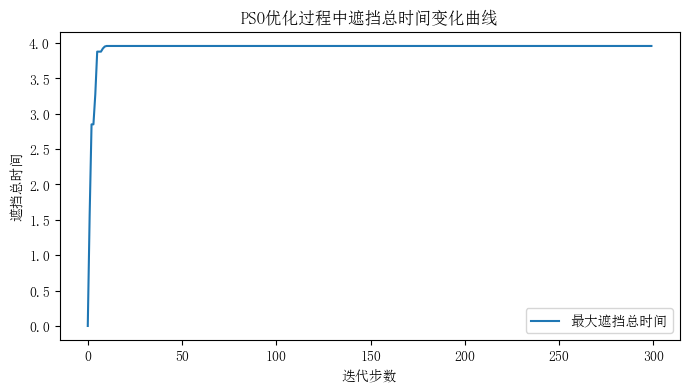

In [5]:
from calc_cover_time import *
from sko.PSO import PSO

cover_time_hist = []
missile_traj = get_missile_traj(M1, fake_target, v_M1, t_list)

def pso_objective(x):
    try:
        speed = x[0]
        direction_angle = x[1]
        t0 = np.clip(x[2], 0, 60)
        t1 = np.clip(max(x[3], t0+1), 0, 60)
        t2 = np.clip(max(x[4], t1+1), 0, 60)
        throw_times = np.array([t0, t1, t2])
        burst_delays = x[5:8]
        smoke_centers = get_smoke_center_multi(f1, direction_angle, speed, throw_times, burst_delays, t_list)
        cover_time = get_missile_cover_time_multi(smoke_centers, missile_traj, true_target, smoke_R, t_list)
        cover_time_hist.append(cover_time)
        return -cover_time
    except Exception:
        return 1e6

# 参数边界
lb = [90, np.pi/2, 0, 1, 2, 0.1, 0.1, 0.1]   # 下界
ub = [140, np.pi*3/2, 10, 50, 60, 10, 10, 10]   # 上界

# 初始化PSO
pso = PSO(func=pso_objective, dim=8, pop=40, max_iter=300, lb=lb, ub=ub)

# 运行PSO
pso.run()
pso_best_x = pso.gbest_x
pso_best_y = -pso.gbest_y  # 目标函数是负值，取反为最大遮挡时间

print("最优参数:", pso_best_x)
print("最大遮挡总时间:", pso_best_y)

# 收敛曲线可用 pso.gbest_y_hist
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot([-y for y in pso.gbest_y_hist], label='最大遮挡总时间')
plt.xlabel('迭代步数')
plt.ylabel('遮挡总时间')
plt.title('PSO优化过程中遮挡总时间变化曲线')
plt.legend()
plt.show()

In [6]:
from scipy.optimize import minimize

# 假设你已经有全局最优解 best_x
def local_objective(x):
    # 与全局目标函数一致
    try:
        speed = x[0]
        direction_angle = x[1]
        t0 = np.clip(x[2], 0, 60)
        t1 = np.clip(max(x[3], t0+1), 0, 60)
        t2 = np.clip(max(x[4], t1+1), 0, 60)
        throw_times = np.array([t0, t1, t2])
        burst_delays = x[5:8]
        smoke_centers = get_smoke_center_multi(f1, direction_angle, speed, throw_times, burst_delays, t_list)
        cover_time = get_missile_cover_time_multi(smoke_centers, missile_traj, true_target, smoke_R, t_list)
        return -cover_time
    except Exception:
        return 1e6

# 局部优化边界
# 以 result.x 为中心，±10%范围
bounds = [(max(70, result.x[0]-7), min(140, result.x[0]+7)),
          (max(np.pi/2, result.x[1]-0.2), min(np.pi*3/2, result.x[1]+0.2)),
          (max(0, result.x[2]-6), min(60, result.x[2]+6)),
          (max(0, result.x[3]-6), min(60, result.x[3]+6)),
          (max(0, result.x[4]-6), min(60, result.x[4]+6)),
          (max(0.1, result.x[5]-0.5), min(20, result.x[5]+0.5)),
          (max(0.1, result.x[6]-0.5), min(20, result.x[6]+0.5)),
          (max(0.1, result.x[7]-0.5), min(20, result.x[7]+0.5))]

# 使用L-BFGS-B进行局部优化
result_local = minimize(local_objective, result.x, bounds=bounds, method='L-BFGS-B')

print("局部优化后参数:", result_local.x)
print("最大遮挡总时间:", -result_local.fun)

局部优化后参数: [1.38496388e+02 3.13266710e+00 4.64258780e-03 3.11481533e+00
 1.23361431e+01 3.73831081e+00 5.02280534e+00 8.14522459e+00]
最大遮挡总时间: 6.586


## 下面是针对四个角的

In [1]:

from calc_cover_time import *
from scipy.optimize import dual_annealing
cover_time_hist = []
missile_traj = get_missile_traj(M1, fake_target, v_M1, t_list)
def sa_objective(x):
    try:
        speed = x[0]
        direction_angle = x[1]
        throw_times = x[2:5]
        burst_delays = x[5:8]
        smoke_centers = get_smoke_center_multi(f1, direction_angle, speed, throw_times, burst_delays, t_list)
        cover_time = get_missile_cover_time_multi_corners(smoke_centers, missile_traj, true_target_corners, smoke_R, t_list)
        cover_time_hist.append(cover_time)
        return -cover_time
    except Exception:
        return 1e6  # 参数非法时返回极小值
# 参数边界：[速度, 角度, 投弹1, 投弹2, 投弹3, 爆炸1, 爆炸2, 爆炸3]
bounds = [
    (result.x[0] * 0.8, result.x[0] * 1.2),           # speed
    (result.x[1] - 0.2, result.x[1] + 0.2),        # angle
    (result.x[2] * 0.8, result.x[2] * 1.2), (result.x[3] * 0.8, result.x[4] * 1.2), (0, 10),  # throw_times
    (0, 10), (0, 10), (0, 10),  # burst_delays
]

from tqdm.notebook import tqdm
max_iter = 3000
pbar = tqdm(total=max_iter, desc="退火优化进度")

# 定义回调函数，每次迭代后更新进度条
def progress_callback(x, f, context):
    pbar.update(1)  # 每次迭代更新进度条

result_corners = dual_annealing(sa_objective,
                         bounds, 
                         maxiter=max_iter, 
                         seed=42,
                         callback=progress_callback,
                         initial_temp=10000,
                         initial_state=result.x
                        )
print("最优参数:", result_corners.x)
print("最大遮挡总时间:", -result_corners.fun)
pbar.close()

退火优化进度:   0%|          | 0/4000 [00:00<?, ?it/s]

最优参数: [80.67101604  3.11649908  0.13484755  1.79790547 16.20000382  3.03286213
  3.14418502 16.29155712]
最大遮挡总时间: 5.538


最优参数: [80.67101604  3.11649908  0.13484755  1.79790547 16.20000382  3.03286213
  3.14418502 16.29155712]
最大遮挡总时间: 5.538
每个烟雾球的遮挡时间及区间：
第1个烟雾球遮挡时间: 3.44s下面是各区间：    区间: 3.17s ~ 6.60s
第2个烟雾球遮挡时间: 3.39s下面是各区间：    区间: 5.31s ~ 8.70s
第3个烟雾球遮挡时间: 0.00s下面是各区间：
总遮挡区间：
    3.17s ~ 8.70s
总遮挡时间: 5.54s


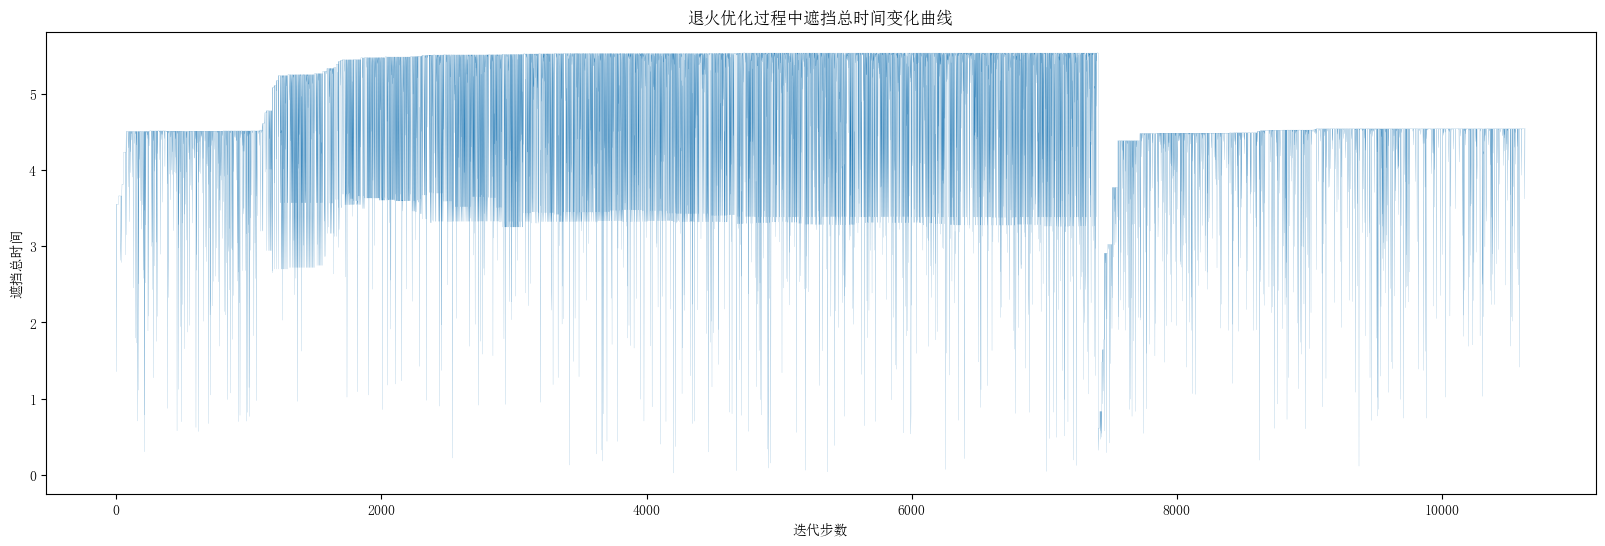

In [2]:
print('最优参数:', result_corners.x)
print('最大遮挡总时间:', -result_corners.fun)


smoke_centers = get_smoke_center_multi(f1, result.x[1], result.x[0], result.x[2:5], result.x[5:8]  , t_list)
cover_time = get_missile_cover_time_multi(smoke_centers, missile_traj, true_target, smoke_R, t_list, debug=True)


plt.figure(figsize=(20,6))
plt.plot([cover_time_01 for cover_time_01 in cover_time_hist[:22000] if cover_time_01 > 0], linewidth=0.1, label='遮挡总时间')
plt.xlabel('迭代步数')
plt.ylabel('遮挡总时间')
plt.title('退火优化过程中遮挡总时间变化曲线')
plt.show()


In [3]:
from scipy.optimize import minimize

# 假设你已经有全局最优解 best_x
def local_objective(x):
    # 与全局目标函数一致
    try:
        speed = x[0]
        direction_angle = x[1]
        t0 = np.clip(x[2], 0, 60)
        t1 = np.clip(max(x[3], t0+1), 0, 60)
        t2 = np.clip(max(x[4], t1+1), 0, 60)
        throw_times = np.array([t0, t1, t2])
        burst_delays = x[5:8]
        smoke_centers = get_smoke_center_multi(f1, direction_angle, speed, throw_times, burst_delays, t_list)
        cover_time = get_missile_cover_time_multi_corners(smoke_centers, missile_traj, true_target_corners, smoke_R, t_list)
        return -cover_time
    except Exception:
        return 1e6

# 局部优化边界
# 以 result.x 为中心，±10%范围
bounds = [(max(70, result_corners.x[0]-7), min(140, result_corners.x[0]+7)),
          (max(np.pi/2, result_corners.x[1]-0.2), min(np.pi*3/2, result_corners.x[1]+0.2)),
          (max(0, result_corners.x[2]-6), min(60, result_corners.x[2]+6)),
          (max(0, result_corners.x[3]-6), min(60, result_corners.x[3]+6)),
          (max(0, result_corners.x[4]-6), min(60, result_corners.x[4]+6)),
          (max(0.1, result_corners.x[5]-0.5), min(20, result_corners.x[5]+0.5)),
          (max(0.1, result_corners.x[6]-0.5), min(20, result_corners.x[6]+0.5)),
          (max(0.1, result_corners.x[7]-0.5), min(20, result_corners.x[7]+0.5))]

# 使用L-BFGS-B进行局部优化
result_corners_local = minimize(local_objective, result_corners.x, bounds=bounds, method='L-BFGS-B')

print("局部优化后参数:", result_local.x)
print("最大遮挡总时间:", -result_local.fun)

局部优化后参数: [80.67101604  3.11649908  0.13484755  1.79790547 16.20000382  3.03286213
  3.14418502 16.29155712]
最大遮挡总时间: 5.538


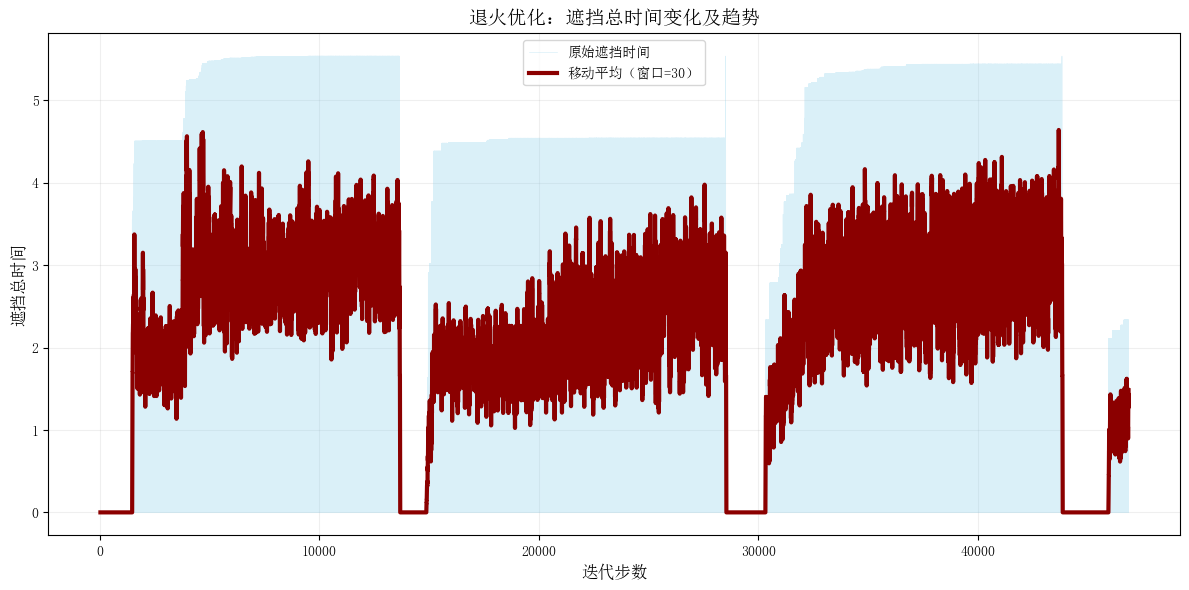

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

# 假设 cover_time_hist 是存储所有迭代遮挡时间的列表
ct_series = pd.Series(cover_time_hist)
window_size = 30  # 移动平均窗口大小，可根据数据密度调整
rolling_avg = ct_series.rolling(window=window_size).mean()

# 绘图
plt.figure(figsize=(12, 6))
# 原始数据：透明+细线，避免视觉拥挤
plt.plot(ct_series.index, ct_series.values, 
         color='skyblue', alpha=0.3, linewidth=0.5, 
         label='原始遮挡时间')
# 移动平均：粗线+醒目颜色，突出趋势
plt.plot(rolling_avg.index, rolling_avg.values, 
         color='darkred', linewidth=3, 
         label=f'移动平均（窗口={window_size}）')

# 美化细节
plt.xlabel('迭代步数', fontsize=12)
plt.ylabel('遮挡总时间', fontsize=12)
plt.title('退火优化：遮挡总时间变化及趋势', fontsize=14)
plt.legend(fontsize=10)
plt.grid(alpha=0.2)  # 浅网格增强可读性
plt.tight_layout()   # 自动调整布局
plt.show()